In [1]:
import pip

if int(pip.__version__.split('.')[0])>9:
    from pip._internal import main
else:
    from pip import main
    
def install(package):
    main(['install', package])

install('BeautifulSoup4')
install('numpy')
install('pandas')
install('matplotlib')

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Looking in indexes: https://artifactory.vertigo.stitchfix.com/artifactory/api/pypi/stitchpy/simple
  Using cached https://artifactory.vertigo.stitchfix.com/artifactory/api/pypi/stitchpy/packages/packages/d1/41/e6495bd7d3781cee623ce23ea6ac73282a373088fcd0ddc809a047b18eae/beautifulsoup4-4.9.3-py3-none-any.whl (115 kB)
  Using cached https://artifactory.vertigo.stitchfix.com/artifactory/api/pypi/stitchpy/packages/packages/36/69/d82d04022f02733bf9a72bc3b96332d360c0c5307096d76f6bb7489f7e57/soupsieve-2.2.1-py3-none-any.whl (33 kB)


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.16_1/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Looking in indexes: https://artifactory.vertigo.stitchfix.com/artifactory/api/pypi/stitchpy/simple


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.16_1/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Looking in indexes: https://artifactory.vertigo.stitchfix.com/artifactory/api/pypi/stitchpy/simple


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.16_1/libexec/bin/python3.9 -m pip install --upgrade pip' command.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


Looking in indexes: https://artifactory.vertigo.stitchfix.com/artifactory/api/pypi/stitchpy/simple


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.16_1/libexec/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import re
from urllib.request import urlopen
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [3]:
seasons = [2014, 2015, 2016, 2017, 2018, 2019, 2020]
weeks = range(1, 17)
pos = {
    "D/ST": 99,
    "RB": 20,
    "WR": 30,
    "QB": 10
}
sample_url = 'https://www.fftoday.com/stats/playerstats.php?Season=2018&GameWeek=1&PosID=99&LeagueID=143908'

url_build = "https://www.fftoday.com/stats/playerstats.php?Season={season}&GameWeek={week}&PosID={pos}&LeagueID=143908"


def positionDataScrape(pos):
    data = []
    for season in seasons:
         for week in weeks:
            data += scrapePosBySeasonWeek(pos, season, week)
    sys.stdout.flush()
    return data

def scrapePosBySeasonWeek(pos, season, week):
    data = []
    url = url_build.format(season=season, week=week, pos=pos)
    sys.stdout.write("\rScrapping {}\t\t".format(url))

    stat_page = urlopen(url)
    stat_soup = BeautifulSoup(stat_page, 'html.parser')
    header = stat_soup.find('tr', class_='tableclmhdr')
    group_header = stat_soup.find('tr', class_='tablehdr')
    rows = header.find_next_siblings('tr')

    group_headers = []
    next_header_index = 0
    for td in group_header.find_all('td')[:-1]: # All group headers minus the last one which is always "Fantasy"
        num_headers = int(td['colspan'])
        group = { 'name': td.get_text().strip(), 'num_headers': num_headers, 'offset': next_header_index }
        group_headers.append(group)
        next_header_index += num_headers

    keys = []
    for td in header.find_all('td'):
        keys.append(td.get_text().strip())

    for group in group_headers:
        if group["name"] == '':
            continue
        span = slice(group['offset'], group['offset'] + group['num_headers'])
        keys[span] = ["{} - {}".format(group['name'], k) for k in keys[span]]


    keys.append('Season')
    keys.append('Week')


    for tr in rows:
        game = {k:None for k in keys}
        i = 0
        for td in tr.find_all('td'):
            game[keys[i]] = td.get_text().strip()
            i += 1
        game['Season'] = season
        game['Week'] = week
        game[keys[0]] = re.sub('^[\W\d]+', '', game[keys[0]])
        game[keys[0]] = re.sub('[\n\r\t]+', '', game[keys[0]])
        game[keys[0]] = re.sub('(s|S)ort\s', '', game[keys[0]]) # Remove the word "sort"
        data.append(game)
        
    return data

def customDefScoring(game):
    score = 0.0
    score += standardDefPts(game)
    if game['PA'] == 0:
        score += 20
    elif game['PA'] <= 6:
        score += 15
    elif game['PA'] <= 13:
        score += 10
    elif game['PA'] <= 20:
        score += 5
    elif game['PA'] <= 27:
        score += 0
    elif game['PA'] <= 34:
        score += -5
    elif game['PA'] >= 35:
        score += -10

    return score

def standardDefPts(game):
    return (1 * game['Sack']) + (2 * game['INT']) + (6 * game['DefTD']) + (6 * game['KickTD']) + (2 * game['Safety'])

In [4]:
data = positionDataScrape(pos["D/ST"])

Scrapping https://www.fftoday.com/stats/playerstats.php?Season=2020&GameWeek=16&PosID=99&LeagueID=143908		

In [5]:
df = pd.DataFrame(data)
df = df.astype({k:'float64' for k in df.columns[1:-2]})

In [6]:
df['CustFPts'] = df.apply(customDefScoring, axis=1)
df['ProposedCustFPts'] = df.apply(customDefScoring, axis=1)

In [7]:
wr_data = positionDataScrape(pos['WR'])

Scrapping https://www.fftoday.com/stats/playerstats.php?Season=2020&GameWeek=16&PosID=30&LeagueID=143908		

In [8]:
wr_df = pd.DataFrame(wr_data)
wr_df = wr_df.astype({k:'float64' for k in wr_df.columns[2:-2]})

In [9]:
rb_data = positionDataScrape(pos['RB'])
rb_df = pd.DataFrame(rb_data)
rb_df = rb_df.astype({k:'float64' for k in rb_df.columns[2:-2]})

Scrapping https://www.fftoday.com/stats/playerstats.php?Season=2020&GameWeek=16&PosID=20&LeagueID=143908		

In [10]:
qb_data = positionDataScrape(pos['QB'])
qb_df = pd.DataFrame(qb_data)
qb_df = qb_df.astype({k:'float64' for k in qb_df.columns[2:-2]})

Scrapping https://www.fftoday.com/stats/playerstats.php?Season=2020&GameWeek=16&PosID=10&LeagueID=143908		

In [11]:
qb_df['CustFPts'] = qb_df.apply(lambda game: game['FPts'] + (game['Passing - INT'] * -1) + (game['Passing - TD'] * 2) + (game['Passing - Yard'] * 0.04), axis=1)
# qb_df['CustFPts'] = qb_df.apply(lambda game: (game['Passing - INT'] * -3) + (game['Passing - TD'] * 6) + (game['Passing - Yard'] * 0.05) + (game['Rushing - Yard'] * 0.01) + (game['Rushing - TD'] * 6), axis=1)

In [12]:
# Update column names to strip out all the weird values.
qb_df.columns.values[0] = 'Player'
wr_df.columns.values[0] = 'Player'
rb_df.columns.values[0] = 'Player'

# Recomputes helper methods for us
qb_df.columns = qb_df.columns.values
wr_df.columns = wr_df.columns.values
rb_df.columns = rb_df.columns.values

# Playing for Keeps - Custom Scoring System

## TL;DR

The goal of the league was to have a fantasy league that was more like the NFL. To do this, we implemented new league rules, like trading draft picks and having keepers, and scoring rule changes. These scoring rules had 2 goals: 

- Make fantasy scoring easier to keep track of while on the couch
    - QB passing touchdowns are 6 points (instead of 4)
    - QB passing yards are a half point for every 10 yards (instead of .4 points per 10 yards)
    - Kickers are 3 points for any field goal (instead of distance affecting points)
    - Defenses start at 28 points. Every time the opponent scores a touchdown, your defense loses a touchdown (7 points) from the starting score.
- Make fantasy points more equal to real life value
    - Increased scoring for QBs makes them the highest scoring, thus ‘most valuable’ player on the field
    - Increased scoring for defenses made them similar in value to a QB, as defense is half of the NFL 

For Defensive scoring, points allowed is the main driver for points:

- 0 points allowed: 	20 points
- 1-6 points allowed: 	15 points
- 7-13 points allowed: 	10 points
- 14-20 points allowed: 5 points
- 21-27 points allowed: 0 points
- 28-34 points allowed: -5 points
- 35+ points allowed: 	-10 points

All other defensive scoring rules follow standard scoring.

You can look at the [stats section](#stats-appendix) for all the info we have on the current D/ST scoring (including team by team stats by season).

Text(0, 0.5, '# of player games')

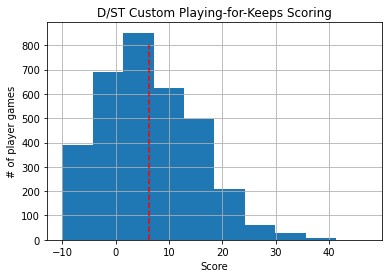

In [13]:
df.CustFPts.hist()
plt.title("D/ST Custom Playing-for-Keeps Scoring")
plt.vlines(df.CustFPts.mean(), 0, 800, ['r'], 'dashed', 'avg')
plt.xlabel("Score")
plt.ylabel("# of player games")

In [14]:
df.where(df.PA == 0)[['FPts', 'CustFPts']].describe(percentiles=[0.25,0.50,0.75,0.90])

,FPts,CustFPts
count,35.000000,35.000000
mean,10.514286,29.085714
std,5.543260,5.370789
min,3.000000,23.000000
25%,6.500000,25.000000
50%,8.000000,28.000000
75%,13.500000,32.000000
90%,17.000000,35.400000
max,27.000000,47.000000


### Volatility in D/ST fantasy points

In stats, "volatility" this is called "standard deviation". Typically, standard deviation is a good indicator of "volatility". If the standard deviation is way higher than the average (aka the "mean"), then getting a score near the average is very "uncertain".

It's easier if we visualize it:

Text(0, 0.5, '# of player games')

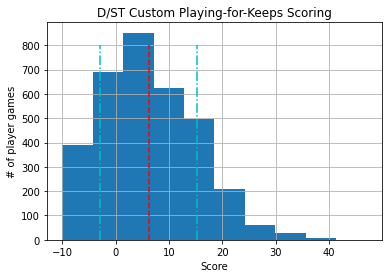

In [15]:
df_avg = df.CustFPts.mean()
df_std = df.CustFPts.std()
df.CustFPts.hist()
plt.title("D/ST Custom Playing-for-Keeps Scoring")
plt.vlines([df_avg, df_avg + df_std, df_avg - df_std], 0, 800, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")

The red line in the middle is the average, the cyan lines on either side are "1 standard deviation" away from the average. The wider the space between the blue bars, the more **dramatic** the volitility. However, all the dark blue inside that "1 standard deviation" range tells us how many games were in that range. You can see that there are a _lot_ of games covered inside the two cyan bars.

To be precise, the pecentage of games within 1 standard deviation of the average fantasy score is:

In [16]:
df_games_within_one_std = df.where(df.CustFPts >= (df_avg - df_std)).where(df.CustFPts <= (df_avg + df_std)).G.count() / df.G.count()
print("{0:.0%}".format(df_games_within_one_std))

66%


The closer to `50%` *and* the *wider* the 1 standard deviation range, the **more** volitile the fantasy score is.

Another way to say all this information is:

In [17]:
print("There is a {0:.0%} chance of my D/ST scoring {1:.2f} ± {2:.2f} points".format(df_games_within_one_std, df_avg, df_std))

There is a 66% chance of my D/ST scoring 6.16 ± 9.04 points


That means, as a GM, D/ST is a big risk-reward player. It could really hurt you on a bad week, but _really_ help you on a good week. That _doesn't_ tell us, though, how _likely_ you are to get a bad week versus a good week.

However, we're used to that same meta with another position, the QB.

67% of games are within 1 standard deviation
There is a 67% chance of my QB scoring 24.89 ± 14.65 points


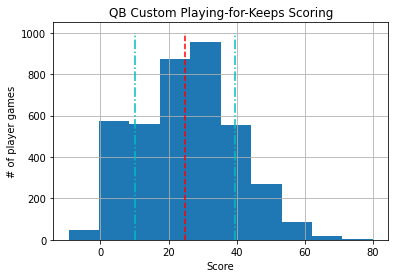

In [18]:
qb_avg = qb_df.CustFPts.mean()
qb_std = qb_df.CustFPts.std()
qb_within_bd_games = qb_df.where(qb_df.CustFPts >= (qb_avg - qb_std)).where(qb_df.CustFPts <= (qb_avg + qb_std)).G.count() / qb_df.G.count()
qb_df.CustFPts.hist()
plt.title("QB Custom Playing-for-Keeps Scoring")
plt.vlines([qb_avg, qb_avg + qb_std, qb_avg - qb_std], 0, 1000, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("{0:.0%} of games are within 1 standard deviation".format(qb_within_bd_games))
print("There is a {0:.0%} chance of my QB scoring {1:.2f} ± {2:.2f} points".format(qb_within_bd_games, qb_avg, qb_std))

# stats-appendix

In [19]:
pd.options.display.max_rows = 500
print('"count" means the number of games in the table below... sorry')
df.groupby(by=["Team", "Season"])[["CustFPts"]].describe()

"count" means the number of games in the table below... sorry


CustFPts                                                \
                        count       mean        std   min   25%   50%   75%   
Team          Season                                                          
Bears         2014       15.0   4.266667  10.559131  -9.0  -3.5   3.0  14.5   
              2015       15.0   3.466667   7.366591  -9.0  -1.0   4.0   8.5   
              2016       15.0   4.733333   9.160994 -10.0  -0.5   3.0  10.0   
              2017       15.0   8.066667   9.888425  -8.0   2.5   8.0  14.0   
              2018       15.0  13.200000  10.303952  -7.0  10.5  13.0  18.0   
              2019       15.0   7.666667   7.384024  -3.0   1.5   7.0  11.5   
              2020       15.0   6.533333   7.327703 -10.0   3.0   6.0  11.5   
Bengals       2014       15.0   6.800000  10.570849 -10.0   1.0  10.0  13.0   
              2015       15.0  10.333333   7.422617  -1.0   4.5  11.0  15.0   
              2016       15.0   6.133333   7.347173  -7.0   2.0   5.0  11.5   
              2017       15.0   6.800000   6.471917  -5.0   1.5   9.0  12.5   
              2018       15.0   2.200000   9.792125 -10.0  -5.5   2.0   9.0   
              2019       15.0   2.600000   7.566845  -8.0  -1.5   2.0   6.0   
              2020       15.0   1.866667   7.029191 -10.0  -3.5   5.0   7.5   
Bills         2014       15.0  10.866667   9.022723  -8.0   5.0  11.0  17.5   
              2015       15.0   5.533333   9.077969  -9.0  -0.5   5.0  12.5   
              2016       15.0   6.666667  11.049671 -10.0  -3.0   6.0  15.0   
              2017       15.0   7.200000   9.151112 -10.0   1.5  11.0  14.5   
              2018       15.0   5.133333   9.241727  -8.0  -0.5   5.0  12.0   
              2019       15.0  10.066667   6.638273  -2.0   8.0  10.0  13.0   
              2020       15.0   5.533333   8.052211 -10.0   0.5   4.0  11.5   
Broncos       2014       15.0   6.600000   7.336796  -7.0   4.0   7.0  13.0   
              2015       15.0  11.800000   8.273883  -3.0   7.0  12.0  16.5   
              2016       15.0   9.466667   8.806383  -3.0   2.0  10.0  15.5   
              2017       15.0   5.333333   8.755950  -9.0   1.0   3.0   9.0   
              2018       15.0   8.000000   8.783101  -2.0   1.5   7.0  10.0   
              2019       15.0   7.933333   8.455486  -4.0   5.0   7.0   9.5   
              2020       15.0   2.400000   8.390471 -10.0  -2.0   1.0   6.5   
Browns        2014       15.0   8.000000   7.387248  -2.0   2.0   8.0  12.5   
              2015       15.0   2.333333   8.372290  -9.0  -3.0  -2.0   6.5   
              2016       15.0  -0.266667   4.415341 -10.0  -3.0   0.0   2.5   
              2017       15.0   2.933333   5.257195  -4.0  -2.0   3.0   6.5   
              2018       15.0   4.733333   6.818742  -7.0  -1.5   8.0  10.0   
              2019       15.0   5.266667   9.098404  -8.0  -2.5   6.0   9.5   
              2020       15.0   3.533333   9.760464  -8.0  -5.0   1.0  12.5   
Buccaneers    2014       15.0   5.200000   7.793770 -10.0   1.5   6.0   7.0   
              2015       15.0   4.933333   8.539544  -8.0   0.0   3.0   9.5   
              2016       15.0   6.200000  10.711809  -9.0  -2.0   4.0  11.5   
              2017       15.0   4.600000   8.666850  -5.0  -2.0   4.0   8.5   
              2018       15.0   1.266667   8.497619  -9.0  -5.0   0.0   6.0   
              2019       15.0   3.666667   9.626353  -9.0  -3.5   4.0   7.5   
              2020       15.0   7.666667   9.263343  -9.0   2.5   7.0  12.5   
Cardinals     2014       15.0  10.666667   9.529403  -9.0   6.5  11.0  18.0   
              2015       15.0  12.266667  10.673510  -1.0   4.5  10.0  17.0   
              2016       15.0   6.066667   9.277212  -5.0   0.0   3.0  10.5   
              2017       15.0   6.333333  10.265523  -4.0  -2.0   5.0  13.0   
              2018       15.0   3.800000   7.494760  -8.0  -2.0   5.0   8.0   
              2019       15.0   1.200000   5.918494  -8.0  -3.5   2.0  

avg: 6.1, standard deviation: 4.7
43 games at 21+ Fantasy Points (roughly 1.3% of games)
73% of games are within 1 standard deviation of the average fantasy score


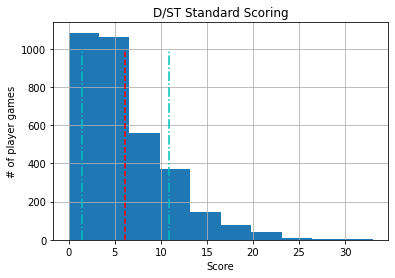

In [20]:
avg = df.FPts.mean()
std = df.FPts.std()
df.FPts.hist()
plt.title("D/ST Standard Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 1000, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(df.where(df.FPts > 20).G.count(), df.where(df.FPts > 20).G.count() / df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(df.where(df.FPts >= (avg - std)).where(df.FPts <= (avg + std)).G.count() / df.G.count()))

avg: 6.2, standard deviation: 9.0
228 games at 21+ Fantasy Points (roughly 6.8% of games)
66% of games are within 1 standard deviation of the average fantasy score


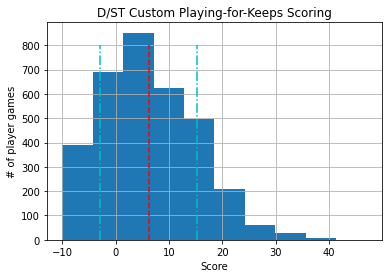

In [21]:
avg = df.CustFPts.mean()
std = df.CustFPts.std()
df.CustFPts.hist()
plt.title("D/ST Custom Playing-for-Keeps Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 800, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(df.where(df.CustFPts > 20).G.count(), df.where(df.CustFPts > 20).G.count() / df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(df.where(df.CustFPts >= (avg - std)).where(df.CustFPts <= (avg + std)).G.count() / df.G.count()))

avg: 10.8, standard deviation: 5.5
378 games at 21+ Fantasy Points (roughly 6.8% of games)
75% of games are within 1 standard deviation of the average fantasy score


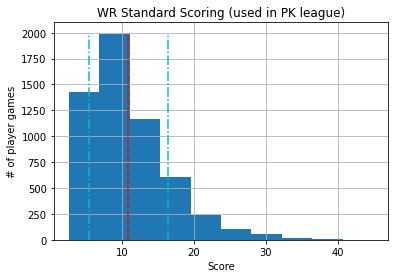

In [22]:
avg = wr_df.FPts.mean()
std = wr_df.FPts.std()
wr_df.FPts.hist()
plt.title("WR Standard Scoring (used in PK league)")
plt.vlines([avg, avg + std, avg - std], 0, 2000, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(wr_df.where(wr_df.FPts > 20).G.count(), wr_df.where(wr_df.FPts > 20).G.count() / wr_df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(wr_df.where(wr_df.FPts >= (avg - std)).where(wr_df.FPts <= (avg + std)).G.count() / wr_df.G.count()))

avg: 10.2, standard deviation: 6.8
546 games at 21+ Fantasy Points (roughly 9.8% of games)
76% of games are within 1 standard deviation of the average fantasy score


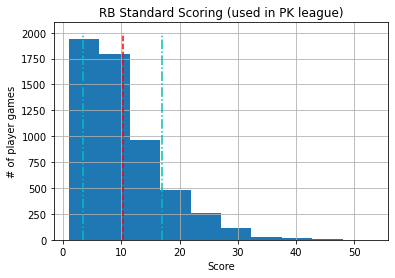

In [23]:
avg = rb_df.FPts.mean()
std = rb_df.FPts.std()
rb_df.FPts.hist()
plt.title("RB Standard Scoring (used in PK league)")
plt.vlines([avg, avg + std, avg - std], 0, 2000, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(rb_df.where(rb_df.FPts > 20).G.count(), rb_df.where(rb_df.FPts > 20).G.count() / rb_df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(rb_df.where(rb_df.FPts >= (avg - std)).where(rb_df.FPts <= (avg + std)).G.count() / rb_df.G.count()))

avg: 24.9, standard deviation: 14.7
2544 games at 21+ Fantasy Points (roughly 64.7% of games)
67% of games are within 1 standard deviation of the average fantasy score


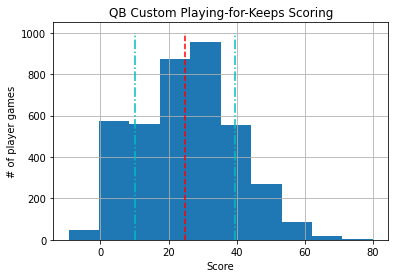

In [24]:
avg = qb_df.CustFPts.mean()
std = qb_df.CustFPts.std()
qb_df.CustFPts.hist()
plt.title("QB Custom Playing-for-Keeps Scoring")
plt.vlines([avg, avg + std, avg - std], 0, 1000, ['r', 'c', 'c'], ['dashed', 'dashdot', 'dashdot'])
plt.xlabel("Score")
plt.ylabel("# of player games")
print("avg: {:.1f}, standard deviation: {:.1f}".format(avg, std))
print("{} games at 21+ Fantasy Points (roughly {:.1%} of games)".format(qb_df.where(qb_df.CustFPts > 20).G.count(), qb_df.where(qb_df.CustFPts > 20).G.count() / qb_df.G.count()))
print("{0:.0%} of games are within 1 standard deviation of the average fantasy score".format(qb_df.where(qb_df.CustFPts >= (avg - std)).where(qb_df.CustFPts <= (avg + std)).G.count() / qb_df.G.count()))

In [25]:
qb_df.where(qb_df.Season == qb_df.Season.max()).groupby('Player').CustFPts.sum().sort_values(ascending=False).head(10)

Player
Patrick Mahomes       627.90
Aaron Rodgers         602.06
Josh Allen            600.50
Deshaun Watson        573.92
Kyler Murray          572.26
Russell Wilson        563.74
Tom Brady             538.06
Ryan Tannehill        509.94
Justin Herbert        505.16
Ben Roethlisberger    471.36
Name: CustFPts, dtype: float64

In [26]:
rb_df.where(rb_df.Season == rb_df.Season.max()).groupby('Player').FPts.sum().sort_values(ascending=False).head(15)

Player
Alvin Kamara        294.8
Dalvin Cook         289.8
Derrick Henry       277.1
James Robinson      199.4
Aaron Jones         197.4
David Montgomery    187.4
Jonathan Taylor     179.4
Josh Jacobs         175.0
Nick Chubb          174.9
Kareem Hunt         173.6
Kenyan Drake        162.1
Ezekiel Elliott     155.7
Antonio Gibson      152.3
Melvin Gordon       151.4
Mike Davis          149.5
Name: FPts, dtype: float64

In [27]:
wr_df.where(wr_df.Season == wr_df.Season.max()).groupby('Player').FPts.sum().sort_values(ascending=False).head(10)

Player
Tyreek Hill         239.4
Davante Adams       225.0
Stefon Diggs        185.3
Calvin Ridley       182.7
DK Metcalf          176.8
Mike Evans          169.3
Adam Thielen        158.8
DeAndre Hopkins     157.4
Allen Robinson      153.9
Justin Jefferson    153.1
Name: FPts, dtype: float64

In [28]:
df.where(df.Season == df.Season.max()).groupby('Team').ProposedCustFPts.sum().sort_values(ascending=False).head(10)

Team
Steelers         153.0
Dolphins         150.0
Rams             138.0
Ravens           128.0
Football Team    127.0
Colts            120.0
Chiefs           117.0
Buccaneers       115.0
Saints           101.0
Bears             98.0
Name: ProposedCustFPts, dtype: float64

In [29]:
qb_df.groupby(['Player','Season']).CustFPts.sum().sort_values(ascending=False).head(10)

Player           Season
Patrick Mahomes  2018      675.34
                 2020      627.90
Lamar Jackson    2019      606.78
Aaron Rodgers    2020      602.06
Josh Allen       2020      600.50
Tom Brady        2015      585.24
Andrew Luck      2014      580.04
Aaron Rodgers    2016      573.92
Deshaun Watson   2020      573.92
Kyler Murray     2020      572.26
Name: CustFPts, dtype: float64

In [30]:
wr_df

,Player,Team,G,Receiving - Target,Receiving - Rec,Receiving - Yard,Receiving - TD,Rushing - Att,Rushing - Yard,Rushing - TD,FPts,FPts/G,Season,Week
0,Calvin Johnson,DET,1.0,11.0,7.0,164.0,2.0,0.0,0.0,0.0,28.4,28.4,2014,1
1,Allen Hurns,JAC,1.0,9.0,4.0,110.0,2.0,0.0,0.0,0.0,23.0,23.0,2014,1
2,A.J. Green,CIN,1.0,9.0,6.0,131.0,1.0,1.0,5.0,0.0,19.6,19.6,2014,1
3,Cordarrelle Patterson,MIN,1.0,5.0,3.0,26.0,0.0,3.0,102.0,1.0,18.8,18.8,2014,1
4,Steve Smith,BAL,1.0,15.0,7.0,118.0,1.0,0.0,0.0,0.0,17.8,17.8,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,Chase Claypool,PIT,1.0,6.0,4.0,54.0,0.0,0.0,0.0,0.0,5.4,5.4,2020,16
5596,Keke Coutee,HOU,1.0,5.0,5.0,54.0,0.0,0.0,0.0,0.0,5.4,5.4,2020,16
5597,Mike Williams,LAC,1.0,10.0,4.0,54.0,0.0,0.0,0.0,0.0,5.4,5.4,2020,16
5598,KeeSean Johnson,ARI,1.0,3.0,2.0,50.0,0.0,0.0,0.0,0.0,5.0,5.0,2020,16


In [79]:
wr_df['FPts/Tgt'] = wr_df.FPts / wr_df['Receiving - Target']


wr_season_df_gb = wr_df.where(wr_df.Season == wr_df.Season.max()).where(wr_df['Receiving - Target'] != 0).rename(columns={'Receiving - Target': 'RecTgts'}).groupby('Player')
wr_season_df = wr_season_df_gb
wr_season_db = wr_season_df

temp_df = ((wr_season_db.FPts.sum() / wr_season_db.RecTgts.sum()) * (wr_season_db.size() / wr_season_db.size().max())).to_frame(name='weighted_pts_per_rec')
temp_df.join(wr_season_db.FPts.sum().to_frame(name='total_pts')).join(wr_season_db.RecTgts.sum().to_frame(name='total_rec')).sort_values(by='weighted_pts_per_rec', ascending=False).head(10)

,weighted_pts_per_rec,total_pts,total_rec
Player,,,
Tyreek Hill,1.827481,239.4,131.0
Mike Evans,1.556506,169.3,101.0
Nelson Agholor,1.538921,117.3,49.0
DK Metcalf,1.443265,176.8,105.0
Adam Thielen,1.383275,158.8,82.0
Davante Adams,1.359890,225.0,130.0
CeeDee Lamb,1.336508,126.3,81.0
A.J. Brown,1.332381,139.9,75.0
Calvin Ridley,1.283607,182.7,122.0


In [41]:
rb_df

,Player,Team,G,Rushing - Att,Rushing - Yard,Rushing - TD,Receiving - Target,Receiving - Rec,Receiving - Yard,Receiving - TD,FPts,FPts/G,Season,Week
0,Le'Veon Bell,PIT,1.0,21.0,109.0,1.0,7.0,6.0,88.0,0.0,25.7,25.7,2014,1
1,Marshawn Lynch,SEA,1.0,20.0,110.0,2.0,1.0,1.0,14.0,0.0,24.4,24.4,2014,1
2,Knowshon Moreno,MIA,1.0,24.0,134.0,1.0,0.0,0.0,0.0,0.0,19.4,19.4,2014,1
3,DeMarco Murray,DAL,1.0,22.0,118.0,1.0,4.0,3.0,25.0,0.0,18.3,18.3,2014,1
4,Mark Ingram,NO,1.0,13.0,60.0,2.0,1.0,1.0,1.0,0.0,18.1,18.1,2014,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,D'Andre Swift,DET,1.0,10.0,45.0,0.0,5.0,4.0,25.0,0.0,5.0,5.0,2020,16
5596,La'Mical Perine,NYJ,1.0,9.0,30.0,0.0,2.0,1.0,14.0,0.0,4.4,4.4,2020,16
5597,Le'Veon Bell,KC,1.0,7.0,30.0,0.0,3.0,1.0,9.0,0.0,3.9,3.9,2020,16
5598,Rodney Smith,CAR,1.0,7.0,23.0,0.0,2.0,2.0,15.0,0.0,3.8,3.8,2020,16


In [66]:
rb_season_df_gb = rb_df.where(rb_df.Season == rb_df.Season.max()).groupby('Player')
#rb_season_df = rb_season_df_gb.size().to_frame(name='num_games').join(rb_season_df_gb.FPts.sum())
rb_season_df = rb_season_df_gb
rb_season_db = rb_season_df

((rb_season_db.FPts.sum()) * (rb_season_db.size() / rb_season_db.size().max())).sort_values(ascending=False).head(20)

Player
Alvin Kamara             294.800000
Derrick Henry            277.100000
Dalvin Cook              270.480000
James Robinson           186.106667
Aaron Jones              171.080000
Jonathan Taylor          167.440000
David Montgomery         162.413333
Kareem Hunt              162.026667
Josh Jacobs              151.666667
Kenyan Drake             151.293333
Melvin Gordon            141.306667
Mike Davis               139.533333
Ezekiel Elliott          134.940000
Nick Chubb               128.260000
Clyde Edwards-Helaire    121.333333
Nyheim Hines             113.026667
Antonio Gibson           111.686667
Todd Gurley              105.040000
Chris Carson             104.500000
Ronald Jones             102.740000
dtype: float64

In [37]:
qb_pts_by_season = qb_df.groupby(['Player','Season']).CustFPts.sum().sort_values(ascending=False)
wr_pts_by_season = wr_df.groupby(['Player', 'Season']).FPts.sum().sort_values(ascending=False)

In [38]:
wr_pts_by_season

Player           Season
Tyreek Hill      2020      239.4
Antonio Brown    2014      226.3
Davante Adams    2020      225.0
Jordy Nelson     2014      218.8
Michael Thomas   2019      217.1
                           ...  
Brian Quick      2015        3.7
Quan Bray        2016        3.6
Vincent Jackson  2016        3.6
Kamar Aiken      2017        3.3
Denarius Moore   2014        2.9
Name: FPts, Length: 1065, dtype: float64